<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/Notebooks/BAF_Exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [1]:
#!git clone https://github.com/MDankloff/Cluster-Bias-Disco.git
#!cd Cluster-Bias-Disco/
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'

Mounted at /content/drive


In [2]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.8 MB/s eta 0:00:00


In [3]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

# Load data and Best LightGBM Models

Sets of features (data columns)

In [4]:
#MASTER DATASET

META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['payment_type', 'days_since_request', 'bank_branch_count_8w', 'credit_risk_score', 'source', 'device_os', 'device_fraud_count','month', 'session_length_in_minutes',
       'velocity_6h', 'velocity_24h', 'velocity_4w', 'email_is_free', 'proposed_credit_limit', 'keep_alive_session'] #, 'intended_balcon_amount']
SEN = ['customer_age', 'income', 'employment_status'] #protected attributes in BAF paper
PROX = ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'zip_count_4w', 'date_of_birth_distinct_emails_4w',
        'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'foreign_request',
        'device_distinct_emails']

################################## SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['payment_type_scaled', 'days_since_request_scaled', 'bank_branch_count_8w_scaled', 'credit_risk_score_scaled',
              'source_scaled', 'device_os_scaled', 'device_fraud_count_scaled','month_scaled', 'session_length_in_minutes_scaled',
              'velocity_6h_scaled', 'velocity_24h_scaled', 'velocity_4w_scaled', 'email_is_free_scaled', 'proposed_credit_limit_scaled', 'keep_alive_session_scaled'] #, 'intended_balcon_amount_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled', 'employment_status_scaled']
PROX_scaled = [['name_email_similarity_scaled', 'prev_address_months_count_scaled', 'current_address_months_count_scaled', 'zip_count_4w_scaled',
                'date_of_birth_distinct_emails_4w_scaled','housing_status_scaled', 'phone_home_valid_scaled', 'phone_mobile_valid_scaled',
                'bank_months_count_scaled', 'has_other_cards_scaled', 'foreign_request_scaled', 'device_distinct_emails_scaled']]

'''Removed features:
'''

'Removed features:\n'

load data from parquet files

In [25]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


load best models from BAF_Reproduce notebook

In [9]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model per variant
modelb = models.get("model_Base_top_4")
modelv1 = models.get("model_Variant I_top_4")
modelv2 = models.get("model_Variant II_top_4")
modelv3 = models.get("model_Variant III_top_0")
modelv4 = models.get("model_Variant IV_top_6")
modelv5 = models.get("model_Variant V_top_0")

# Explore data

In [26]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

In [7]:
#remove features --> check for missing values first
#features_to_remove = ['', '', '', '', '']

#for df_name, df in dataframes.items():
  #for column in features_to_remove:
    #if column in df.columns:
     # df.drop(column, axis=1, inplace=True)


In [75]:
dfs = [base, variant1, variant2, variant3, variant4, variant5]

'''for dfs in dfs:
  print(dfs.isnull().sum())
  print("-" * 20)
'''


# Get the number of unique values in each column of the DataFrame
base.nunique()

,0
fraud_bool,2
income,9
name_email_similarity,998861
prev_address_months_count,374
current_address_months_count,423
customer_age,9
days_since_request,989330
intended_balcon_amount,994971
payment_type,5
zip_count_4w,6306


In [76]:
base.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,12.000000,383.000000
current_address_months_count,1000000.0,86.587867,88.406599,-1.000000e+00,19.000000,52.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


In [77]:
base.describe(include=["object", "bool"]).transpose()

,count,unique,top,freq
payment_type,1000000,5,AB,370554
employment_status,1000000,7,CA,730252
housing_status,1000000,7,BC,372143
source,1000000,2,INTERNET,992952
device_os,1000000,5,other,342728


In [79]:
base_frauds = pd.DataFrame(base['fraud_bool'].value_counts())
print(base_frauds)

             count
fraud_bool        
0           988971
1            11029


missing values

In [81]:
missing_vals = pd.DataFrame()
missing_features = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

#replace -1 values with NaN, calculate percentage of missing values

for feature in missing_features:
  base.loc[base[feature] < 0, feature] = np.nan
  missing_vals_col = base.groupby('fraud_bool')[feature].apply(lambda x: round(x.isna().sum()/len(x)* 100, 2))
  missing_vals[feature] = missing_vals_col

print(missing_vals)

            prev_address_months_count  current_address_months_count  \
fraud_bool                                                            
0                               71.06                          0.43   
1                               91.89                          0.13   

            intended_balcon_amount  bank_months_count  \
fraud_bool                                              
0                            74.09              25.23   
1                            88.38              37.54   

            session_length_in_minutes  device_distinct_emails_8w  
fraud_bool                                                        
0                                0.20                       0.04  
1                                0.16                       0.04  


In [67]:
(base['current_address_months_count']).value_counts()

,count
current_address_months_count,
6,16376
7,16270
8,16089
5,15896
9,15688
...,...
413,1
419,1
403,1


In [46]:
(base['prev_address_months_count']).info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000000 entries, 0 to 999999
Series name: prev_address_months_count
Non-Null Count    Dtype
--------------    -----
1000000 non-null  int64
dtypes: int64(1)
memory usage: 7.6 MB


In [70]:
pd.set_option('display.max_columns', 50) # Increase the maximum number of columns displayed in Pandas to 50

In [73]:
#variant1.iloc[500]
base.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


# Pre-process

In [10]:
#base.head()

In [11]:
base['payment_type']

,payment_type
0,AA
1,AD
2,AB
3,AB
4,AA
...,...
999995,AB
999996,AC
999997,AA
999998,AB


In [12]:
train_dfs = {key: df[df["month"] < 6].sample(frac=1, replace=False) for key, df in dataframes.items()}
test_dfs = {key: df[df["month"] >= 6].sample(frac=1, replace=False) for key, df in dataframes.items()}

In [13]:
def convert_object_to_num(data):
    for column in data.select_dtypes(include=['object']).columns:
        # Convert object to boolean if the values are binary (0/1)
        if data[column].isin([0, 1]).all():  # Checks if the column contains only 0s and 1s
            data[column] = data[column].astype(bool)  # Convert to boolean (True/False)

        # Otherwise, convert to numeric (int or float)
        else:
            try:
                data[column] = pd.to_numeric(data[column], errors='raise', downcast='integer')
            except ValueError:
                # If conversion fails to int, try float
                try:
                    data[column] = pd.to_numeric(data[column], errors='raise', downcast='float')
                except ValueError:
                    # If numeric conversion fails, coerce errors to NaN (handle invalid strings)
                    data[column] = pd.to_numeric(data[column], errors='coerce')
    return data

In [14]:
base_df_cleaned = convert_object_to_num(test_dfs['Base'])
variant1_df_cleaned = convert_object_to_num(test_dfs['Variant I'])
variant2_df_cleaned = convert_object_to_num(test_dfs['Variant II'])
variant3_df_cleaned = convert_object_to_num(test_dfs['Variant III'])
variant4_df_cleaned = convert_object_to_num(test_dfs['Variant IV'])
variant5_df_cleaned = convert_object_to_num(test_dfs['Variant V'])
base_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205011 entries, 928437 to 851579
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        205011 non-null  int64  
 1   income                            205011 non-null  float64
 2   name_email_similarity             205011 non-null  float64
 3   prev_address_months_count         205011 non-null  int64  
 4   current_address_months_count      205011 non-null  int64  
 5   customer_age                      205011 non-null  int64  
 6   days_since_request                205011 non-null  float64
 7   payment_type                      0 non-null       float64
 8   zip_count_4w                      205011 non-null  int64  
 9   bank_branch_count_8w              205011 non-null  int64  
 10  date_of_birth_distinct_emails_4w  205011 non-null  int64  
 11  employment_status                 0 non-null       f

In [15]:
variant3['customer_age'].value_counts()

,count
customer_age,
50,383161
30,188523
20,146955
40,145665
60,99828
70,18690
10,12996
80,3910
90,272


In [16]:
#base['customer_age'].value_counts() #same as variant3

In [17]:
variant1['customer_age'].value_counts()

,count
customer_age,
30,337975
20,268243
40,260103
50,86053
10,22980
60,20031
70,3809
80,751
90,55


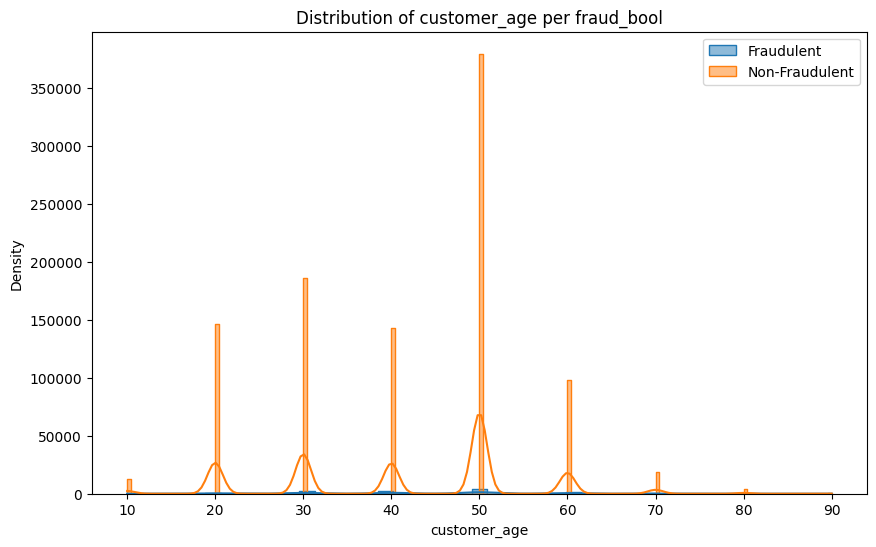

In [18]:
fraud_age = variant3.loc[variant3['fraud_bool'] == 1, 'customer_age']
nonfraud_age = variant3.loc[variant3['fraud_bool'] == 0]['customer_age']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_age, kde=True, label='Fraudulent', element='step')
sns.histplot(nonfraud_age, kde=True, label='Non-Fraudulent', element='step')


plt.title('Distribution of customer_age per fraud_bool')
plt.xlabel('customer_age')
plt.ylabel('Density')
plt.legend()
plt.show()

In [19]:
variant3['income'].value_counts()

,count
income,
0.9,241062
0.8,151514
0.1,145056
0.6,110152
0.7,104981
0.4,78410
0.2,64963
0.5,55077
0.3,48785


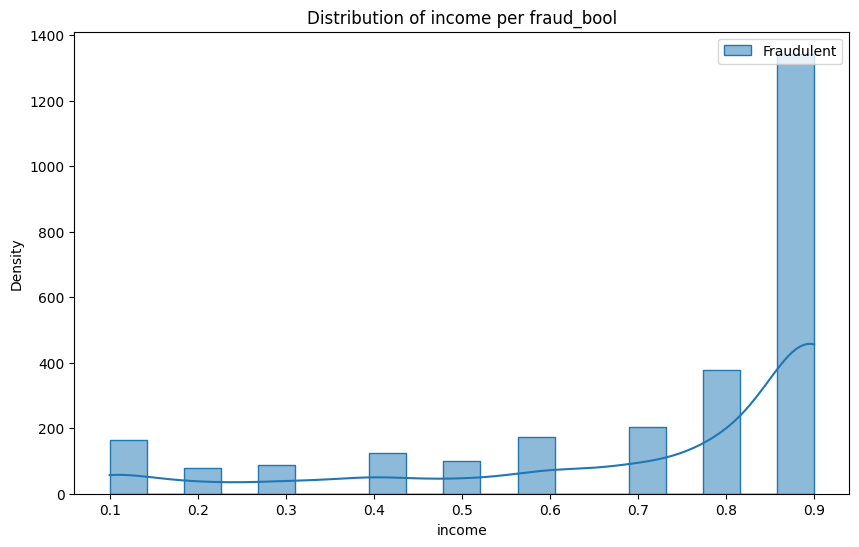

In [20]:
fraud_income = variant3_df_cleaned.loc[variant3_df_cleaned['fraud_bool'] == 1, 'income']
nonfraud_income = variant3_df_cleaned.loc[variant3_df_cleaned['fraud_bool'] == 0]['income']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_income, kde=True, label='Fraudulent', element='step')
sns.histplot()

plt.title('Distribution of income per fraud_bool')
plt.xlabel('income')
plt.ylabel('Density')
plt.legend()
plt.show()

In [21]:
variant3['employment_status'].value_counts()

,count
employment_status,
CA,684981
CB,135133
CC,89089
CF,44943
CD,26648
CE,18719
CG,487


# Get the Errors

In [22]:
def get_errors (model, data, test_dfs):
    """
    Evaluate trained model on test data and compute metrics and errors.
    - model: Trained model (Best LightGBM model)
    - X_test: Feature matrix for the test data
    - Y_test: True labels for the test data

    Returns:
    - metrics: Dictionary containing calculated metrics (accuracy, precision, recall, f1, ROC AUC)
    - predictions: DataFrame containing the true and predicted classes along with errors
    """

    #get train and test data
    X_train = train_dfs[data].drop(columns=["fraud_bool"])
    Y_train = train_dfs[data]["fraud_bool"]
    X_test = test_dfs[data].drop(columns=["fraud_bool"])
    Y_test = test_dfs[data]["fraud_bool"]

    #predict
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC (for class 1)

    # Convert predictions and true labels to integers if they are not already
    Y_pred = Y_pred.astype(int)  # Ensure predictions are integers (0 or 1)
    Y_test = Y_test.astype(int)  # Ensure true labels are integers (0 or 1)

   #get evaluation metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_prob)

    #Print the evaluation metrics & confusion matrix
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Create predictions DataFrame
    predictions = pd.DataFrame({
        'predicted_class': Y_pred,
        'true_class': Y_test,
        'errors': abs(Y_pred - Y_test)
    }, index=X_test.index)

    # Merge predictions with the original test data
    test_dfs[data] = pd.merge(test_dfs[data], predictions, left_index=True, right_index=True, how='outer')


    return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc
    }, predictions

In [23]:
test_dfs['Base']

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,payment_type,zip_count_4w,bank_branch_count_8w,...,phone_mobile_valid,bank_months_count,has_other_cards,foreign_request,source,session_length_in_minutes,device_os,device_distinct_emails_8w,device_fraud_count,month
928437,0,0.4,0.703010,-1,75,30,0.005666,NaN,400,13,...,1,2,0,0,NaN,2.711407,NaN,1,0,7
811518,0,0.2,0.555139,-1,145,10,0.016700,NaN,817,11,...,1,31,0,0,NaN,13.350107,NaN,1,0,6
945628,0,0.4,0.661153,51,8,30,0.010230,NaN,1198,5,...,1,31,0,0,NaN,2.653481,NaN,1,0,7
901927,0,0.9,0.674419,112,20,40,0.016507,NaN,1256,10,...,1,21,1,0,NaN,0.784453,NaN,1,0,6
805167,0,0.9,0.994728,12,10,20,0.031814,NaN,576,10,...,1,31,1,0,NaN,3.378723,NaN,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907962,0,0.7,0.334094,-1,186,20,0.009363,NaN,300,4,...,1,26,1,0,NaN,4.336841,NaN,1,0,7
883969,0,0.8,0.177485,315,0,50,0.027510,NaN,1138,1,...,0,10,0,0,NaN,4.877095,NaN,1,0,6
948142,0,0.8,0.755023,-1,59,30,0.020437,NaN,462,2063,...,1,-1,1,0,NaN,3.305267,NaN,1,0,7
975222,0,0.9,0.675795,-1,64,50,0.018930,NaN,1122,13,...,0,28,0,0,NaN,1.235952,NaN,1,0,7


Add the metrics and errors to all variants

In [24]:
base_metrics, base_error = get_errors(modelb, 'Base', test_dfs)
v1_metrics, v1_error = get_errors(modelv1, 'Variant I', test_dfs)
v2_metrics, v2_error = get_errors(modelv2, 'Variant II', test_dfs)
v3_metrics, v3_error = get_errors(modelv3, 'Variant III', test_dfs)
v4_metrics, v4_error = get_errors(modelv4, 'Variant IV', test_dfs)
v5_metrics, v5_error = get_errors(modelv5, 'Variant V', test_dfs)


#print(test_dfs['Base'].head())  # Includes original columns + true_class, predicted_class, errors
#print(test_dfs['Variant I'].head())  # Includes the same for 'Variant I'

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
# Rename updated datasets to new variables
Base_error = test_dfs['Base']
V1_error = test_dfs['Variant I']
V2_error = test_dfs['Variant II']
V3_error = test_dfs['Variant III']
V4_error = test_dfs['Variant IV']
V5_error = test_dfs['Variant V']

# Get the error labels

In [ ]:
def add_error_labels(df):
    df['TP'] = ((df['true_class'] == 1) & (df['predicted_class'] == 1)).astype(int)
    df['TN'] = ((df['true_class'] == 0) & (df['predicted_class'] == 0)).astype(int)
    df['FN'] = ((df['true_class'] == 1) & (df['predicted_class'] == 0)).astype(int)
    df['FP'] = ((df['true_class'] == 0) & (df['predicted_class'] == 1)).astype(int)
    return df

# Apply the function to each error dataset
Base_error = add_error_labels(Base_error)
V1_error = add_error_labels(V1_error)
V2_error = add_error_labels(V2_error)
V3_error = add_error_labels(V3_error)
V4_error = add_error_labels(V4_error)
V5_error = add_error_labels(V5_error)

In [ ]:
Base_error.head()
#Base_error.iloc[500]

In [ ]:
#Check if there are any FP/FN
#Base_error[Base_error['FN']==1]

# Add SHAP values on testset

In [ ]:
!pip install shap
import shap

 TreeExplainer is specifically optimized for tree-based models such as LightGBM, XGBoost, and CatBoost.

In [ ]:
X_train = (train_dfs[Base_error].drop(columns=["fraud_bool"]))


explainer = shap.TreeExplainer(modelb, X_train)